<a href="https://colab.research.google.com/github/PiotrApriasz/CPMMethod_BOiL/blob/main/DeepFakeAutoencoder_Apriasz_B%C5%82achowicz_AcademicProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Piotr Apriasz i Dawid Błachowicz mają przyjemność przedstawić projekt na przedmiot Podstawy Sztucznej Inteligencji, który opisuje wykorzystanie autoencoderów w tworzeniu filmów deepfake. W projekcie tym wykorzystamy wystąpienia prrezydentów Donalda Trumpa i Joe Bidena z World Economic Forum i na twarz pierwszego nałożymy twarz drugiego tak aby stworzyć iluzję, że słowa wypowiedziane przez Trumpa zostały wypowiedziane przez Bidena. 

Na poczatku zaimportujemy wymagane biblioteki

In [ ]:
import cv2
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
!pip install mtcnn
from mtcnn import MTCNN
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import keras
from keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from IPython.display import clear_output
import dlib
import gc

!pip install pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 8.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Aby wykonać zadanie w środowisku Colab utworzymy wymagane foldery aby móc odpowiednio przechowywać dane na których będziemy pracować

In [ ]:
# ----------- Foldery dla przygotowania danych i trenowania deepfake

!mkdir frames_1
!mkdir frames_2
!mkdir frames_3
!mkdir frames_4
!mkdir results_1_old
!mkdir results_2_old

# ------------ Foldery dla tworzenia deepfake

!mkdir frames
!mkdir results
!mkdir transformed
!mkdir final
!mkdir trained_autoencoders
!mkdir shape_predictor
!ls /content/

# ----------- Foldery dla sprawdzania czy deepfake

!mkdir deepfake_video
!mkdir deepfake_frames
!mkdir deepfake_faces
!mkdir deepfake_result

final	  frames_2  results	   sample_data		 transformed
frames	  frames_3  results_1_old  shape_predictor
frames_1  frames_4  results_2_old  trained_autoencoders


Dla wygody pracy podłązcymy pod środowisko dysk google skąd pobierzemy filmy prezydentów jak i będziemy mogli zapisać na dysku rezultaty naszych prac takie jak wytrenowane modele czy wyekstraktowane twarze ponieważ tworzenie tych danych zajmuje bardzo dużo czasu




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dla wygody przypiszemy do zmiennych odpowiednie ściezki. 

In [ ]:
input_1 = '/content/drive/My Drive/DeepFake/trump1.mp4'
input_2 = '/content/drive/My Drive/DeepFake/trump2.mp4'
input_3 = '/content/drive/My Drive/DeepFake/biden1.mp4'
input_4 = '/content/drive/My Drive/DeepFake/biden2.mp4'
output_1 = '/content/frames_1/'
output_2 = '/content/frames_2/'
output_3 = '/content/frames_3/'
output_4 = '/content/frames_4/'

Jedną z głównych czynności potrzebnych do tego aby przygotować dane jest podzielenie filmów na pojedyncze klatki czyli wyciągnięcie z niego pojedyncze obrazy. Posłuży do tego poniższa funckja

In [ ]:
def extract_frames(input_path,output_path):
    videocapture = cv2.VideoCapture(input_path)
    success,image = videocapture.read()
    count = 0
    while success:
        cv2.imwrite(output_path+"frame%d.jpg" % count, image)     
        success,image = videocapture.read()
        count += 1
    return count

Użycie powyższej funkcji do wyekstraktowania pojedynczych klatek z filmów 

In [ ]:
total_frames_1 = extract_frames(input_1,output_1)
total_frames_2 = extract_frames(input_2,output_2)
total_frames_3 = extract_frames(input_3,output_3)
total_frames_4 = extract_frames(input_4,output_4)

Wypisanie informacji ile zostało znalezionych klatek w filmach

In [ ]:
print('Całkowita ilość klatek wyekstraktowana z filmu 1: ',total_frames_1)
print('Całkowita ilość klatek wyekstraktowana z filmu 2: ',total_frames_2)
print('Całkowita ilość klatek wyekstraktowana z filmu 3: ',total_frames_3)
print('Całkowita ilość klatek wyekstraktowana z filmu 4: ',total_frames_4)

Całkowita ilość klatek wyekstraktowana z filmu 1:  1701
Całkowita ilość klatek wyekstraktowana z filmu 2:  1875
Całkowita ilość klatek wyekstraktowana z filmu 3:  1108
Całkowita ilość klatek wyekstraktowana z filmu 4:  1529


Wyświetlenie wybranej wyekstraktowanej klatki dla obu prezydentów

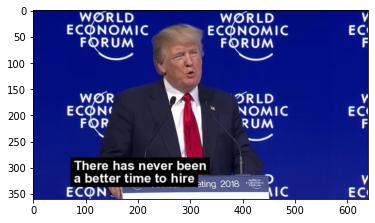

In [ ]:
%matplotlib inline
plt.figure()
image = cv2.imread('/content/frames_1/frame1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.astype('float32')
image /= 255.0
plt.imshow(image)
plt.show()

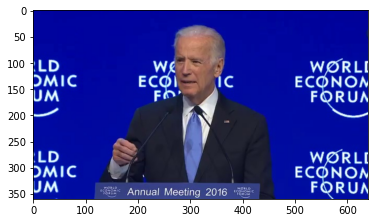

In [ ]:
%matplotlib inline
plt.figure()
image = cv2.imread('/content/frames_3/frame1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

Cały czas jednak na wejście autoencoderów nie możemy podać wyżej utworzonych klatek ponieważ nie wyszkolilibyśmy ich w taki sposób jaki chcemy. To znaczy chcemy abby autoencoder skupiał się tylko na twarzach a nie na reszcie kadru. Aby to osiągnąć musimy z klatek filmów wyciąć tylko twarze. Posłuży nam do tego zaimportowany detektor MTCNN który bardzo dobrze radzi sobie ze znajdowanie twarzy na obrazach. Detekcja zostanie trochę zmodyfikowana aby detektor znajdował całą twarz a nie tylko częsć gdzie znajdują sie oczy, usta i nos. Warto zauważć, że detekcja twarzy dla tylu klatek trwała około 2 godziny

In [ ]:
def extract_faces(source_1,source_2,destination,detector):
    counter = 0
    for dirname, _, filenames in os.walk(source_1):
        for filename in filenames:
            try:
                image = cv2.imread(os.path.join(dirname, filename))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                detections = detector.detect_faces(image)
                x, y, width, height = detections[0]['box']
                x1,y1,x2,y2 = x-10,y+10,x-10 +width + 20,y+10+height
                face = image[y1:y2, x1:x2]
                face = cv2.resize(face, (120, 120), interpolation=cv2.INTER_LINEAR)
                plt.imsave(os.path.join(destination,str(counter)+'.jpg'),face)
                print('Saved: ',os.path.join(destination,str(counter)+'.jpg'))
            except:
                pass
            counter += 1
    for dirname, _, filenames in os.walk(source_2):
        for filename in filenames:
            try:
                image = cv2.imread(os.path.join(dirname, filename))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                detections = detector.detect_faces(image)
                x, y, width, height = detections[0]['box']
                x1,y1,x2,y2 = x-10,y+10,x-10 +width + 20,y+10+height
                face = image[y1:y2, x1:x2]
                face = cv2.resize(face, (120, 120), interpolation=cv2.INTER_LINEAR)
                plt.imsave(os.path.join(destination,str(counter)+'.jpg'),face)
                print('Saved: ',os.path.join(destination,str(counter)+'.jpg'))
            except:
                pass
            counter += 1

Wywołanie powyższej metody na przygotowanych klatkach

In [ ]:
detector = MTCNN()
extract_faces('/content/frames_1/','/content/frames_2/', '/content/results_1/',detector)
extract_faces('/content/frames_3/','/content/frames_4/', '/content/results_2/',detector)

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
Saved:  /content/results_1/1213.jpg
Saved:  /content/results_1/1214.jpg
Saved:  /content/results_1/1215.jpg
Saved:  /content/results_1/1216.jpg
Saved:  /content/results_1/1217.jpg
Saved:  /content/results_1/1218.jpg
Saved:  /content/results_1/1219.jpg
Saved:  /content/results_1/1220.jpg
Saved:  /content/results_1/1221.jpg
Saved:  /content/results_1/1222.jpg
Saved:  /content/results_1/1223.jpg
Saved:  /content/results_1/1224.jpg
Saved:  /content/results_1/1225.jpg
Saved:  /content/results_1/1226.jpg
Saved:  /content/results_1/1227.jpg
Saved:  /content/results_1/1228.jpg
Saved:  /content/results_1/1229.jpg
Saved:  /content/results_1/1230.jpg
Saved:  /content/results_1/1231.jpg
Saved:  /content/results_1/1232.jpg
Saved:  /content/results_1/1233.jpg
Saved:  /content/results_1/1234.jpg
Saved:  /content/results_1/1235.jpg
Saved:  /content/results_1/1236.jpg
Saved:  /content/results_1/1237.jpg
Saved:  /content/results_1/1238.jpg

Wyświetlenie wybranych obrazów twarzy, które zostały odnalezione na klatkach filmów

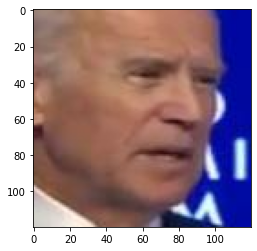

In [ ]:
%matplotlib inline
plt.figure()
image = cv2.imread('/content/results_2/700.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

Spakowanie i Pobranie przygotowanych obrazów aby można było je wykorzystać później. Znajdowanie twarzy na klatkach trwa długo więc kolejnym razem prześlemy je z dysku na serwer aby były od razu dostępne do trenowania sieci

In [ ]:
!zip -r /content/trump_faces.zip /content/results_1/
!zip -r /content/biden_faces.zip /content/results_2/

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  adding: content/results_1/1764.jpg (deflated 5%)
  adding: content/results_1/2727.jpg (deflated 5%)
  adding: content/results_1/916.jpg (deflated 5%)
  adding: content/results_1/2014.jpg (deflated 5%)
  adding: content/results_1/184.jpg (deflated 5%)
  adding: content/results_1/3490.jpg (deflated 5%)
  adding: content/results_1/3343.jpg (deflated 5%)
  adding: content/results_1/932.jpg (deflated 5%)
  adding: content/results_1/2232.jpg (deflated 5%)
  adding: content/results_1/486.jpg (deflated 5%)
  adding: content/results_1/370.jpg (deflated 6%)
  adding: content/results_1/3072.jpg (deflated 5%)
  adding: content/results_1/1174.jpg (deflated 5%)
  adding: content/results_1/2989.jpg (deflated 5%)
  adding: content/results_1/1663.jpg (deflated 5%)
  adding: content/results_1/1468.jpg (deflated 5%)
  adding: content/results_1/3010.jpg (deflated 5%)
  adding: content/results_1/3532.jpg (deflated 5%)
  adding: content/resu

Skopiowanie utworzonych klatek z twarzami z dysku do środowiska google colab

In [ ]:
!cp -r '/content/drive/My Drive/DeepFake/results_1/' /content/
!cp -r '/content/drive/My Drive/DeepFake/results2' /content/

Funkcja, przygotowująca otrzymane twarze tak aby model autoencodera mógł je zrozumieć. Wizja komputerowa jest oczywiście inna niż to jak widzi człowiek więc obrazy muszą być wcześniej specjalnie przygotowane aby były zrozumiałe dla komputera

In [ ]:
def create_dataset(path):
    images = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            if filename != 'desktop.ini':
              image = cv2.imread(os.path.join(dirname, filename))
              image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
              image = image.astype('float32')
              image /= 255.0
              images.append(image)
    images = np.array(images)
    return images

Wywołanie powyższej funkcji

In [ ]:
faces_1 = create_dataset('/content/results_1/')
faces_2 = create_dataset('/content/results2/')

Aby można było szkolić autoencoder utworzone powyżej obrazy należy podzielić na datasety do treningu. Istotne dla nas będą sety X-owe ponieważ w nauce naszych modeli nie używamy oznaczeń dla setów. Do podzielenia onrazów na sety używamy standardowej funckcji train_test_split z bibliotki sklearn

In [ ]:
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(faces_1, faces_1, test_size=0.20, random_state=0)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(faces_2, faces_2, test_size=0.15, random_state=0)

Przejdziemy teraz do tworzenia modelu autoencoderów. Na poczatku utworzymy sieć dla encodera. Na poczatku ustalamy jakie rozmiary będzie mieć obraz podawany na wejściu. Będzie to 120x120. W kolejnych linijkach ustawiamy poszzcególne parametry dla sieci. Conv2D tworzy konwulcyjną dwuwymiarową warstwę neuronową. Pierwszym argumentem jest rozmiar wyjścia z warstwy, ilość filtrów znajdujących się w tej warstwie. Drugim argumentem jest wysokośc i szerokość warstwy. Trzecim ragument jest ilośc korków dla danej warstwy. Activation to funckja aktywacji i w tym wypadku używamy relu która bezpośrednio wyrzuci na wyjscie input jeśli jest dodatni a jeśli nie to wyrzuci 0. 
MaxPolling słuzy do zmniejszania wymiarów wejścia,  czyli w tym wypadku będą zmienjaszane wymiary obrazów podawanych na poszzcególne warstwy encodera. 
Flatten spłaszcza dane wejściowe aby miały one mniejszy rozmiar. Metody Dense i reshape ustalają ostateczny kształt warstwy. Na końcu ustalamy wejście i wyjśice modelu i nadajemy mu nazwę

In [ ]:
input_img = layers.Input(shape=(120, 120, 3))
x = layers.Conv2D(256,kernel_size=5, strides=2, padding='same',activation='relu')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(512,kernel_size=5, strides=2, padding='same',activation='relu')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(1024,kernel_size=5, strides=2, padding='same',activation='relu')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(9216)(x)
encoded = layers.Reshape((3,3,1024))(x)
encoder = keras.Model(input_img, encoded,name="encoder")

Utworzenie struktury decodera. Analogicznie jak wyżej

In [ ]:
decoder_input= layers.Input(shape=((3,3,1024)))
x = layers.Conv2D(1024,kernel_size=5, strides=2, padding='same',activation='relu')(decoder_input)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(512,kernel_size=5, strides=2, padding='same',activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(256,kernel_size=5, strides=2, padding='same',activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(np.prod((120, 120, 3)))(x)
decoded = layers.Reshape((120, 120, 3))(x)
decoder = keras.Model(decoder_input, decoded,name="decoder")

Ustalamy tutaj ostatecznie wejście dla encodera i decodera i kompilujemy utworzone sieci korzystjąc z optymalizatora Adam i funkcji straty mae. Funckja straty pomoże uczyć autoencoder i będzie go informować o tym z jakim błędem odtworrzył obrazy z wejścia. Dzięki temu z każdą epoką będzie się on starał tak kodować obrazy aby można je było później z łatwością odtworzyć. 

In [ ]:
auto_input = layers.Input(shape=(120,120,3))
encoded = encoder(auto_input)
decoded = decoder(encoded)
 
autoencoder = keras.Model(auto_input, decoded,name="autoencoder")
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(lr=5e-5, beta_1=0.5, beta_2=0.999), loss='mae')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 encoder (Functional)        (None, 3, 3, 1024)        54162944  
                                                                 
 decoder (Functional)        (None, 120, 120, 3)       86880192  
                                                                 
Total params: 141,043,136
Trainable params: 141,043,136
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Rozpoczęcie uczenia autoencodera na podstawie klatek z Donaldem Trumpem. Ustalamy ilość epok na 2700. Jest to za mała ilość aby autoencoder poradził sobie dobrze z tworzeniem deepfeka. Wystarczającą ilością było by jakies 20000 epok jednak taka ilość spowodowałaby, że uczenie mogło by trwać nawet 2 dni. W naszym przypadku nauka autoencoderów dla dwóch prezydentów trwały po około 4 godziny. Trenowany model zapisujemy w checkpointie aktualizując zapis tylko wtedy kiedy wartość z funckji straty się poprawi to znaczy zmnniejszy. 

In [ ]:
checkpoint1 = ModelCheckpoint("/content/autoencoder_a.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='auto', period=1)
history1 = autoencoder.fit(X_train_a, X_train_a, epochs=2700, batch_size=512, shuffle=True, validation_data=(X_test_a, X_test_a), callbacks=[checkpoint1])

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
Epoch 1451/2700
3/3 [==============================] - ETA: 0s - loss: 0.0352
Epoch 1451: val_loss did not improve from 0.03202
3/3 [==============================] - 4s 1s/step - loss: 0.0352 - val_loss: 0.0378
Epoch 1452/2700
3/3 [==============================] - ETA: 0s - loss: 0.0372
Epoch 1452: val_loss did not improve from 0.03202
3/3 [==============================] - 4s 1s/step - loss: 0.0372 - val_loss: 0.0359
Epoch 1453/2700
3/3 [==============================] - ETA: 0s - loss: 0.0360
Epoch 1453: val_loss did not improve from 0.03202
3/3 [==============================] - 4s 1s/step - loss: 0.0360 - val_loss: 0.0358
Epoch 1454/2700
3/3 [==============================] - ETA: 0s - loss: 0.0357
Epoch 1454: val_loss did not improve from 0.03202
3/3 [==============================] - 4s 1s/step - loss: 0.0357 - val_loss: 0.0366
Epoch 1455/2700
3/3 [==============================] - ETA: 0s - loss: 0.0362
Epoch 145

In [ ]:
!cp '/content/drive/My Drive/DeepFake/autoencoder_a.hdf5' /content/trained_autoencoders/

Porównamy teraz obraz testowy z obrazem otrzymanym z pierwszego autoencodera. Sprawdzimy też jaka jest wartość błędu z jaką pracuje autoencoder. Tutaj wynosi on 0.0254. Jest to wartość niska ale jak widać nie na tyle niska aby autoencoder perfecyjnie poradził sobie z odtworzniem obrazu. Widać, że jest on lekko rozmyty

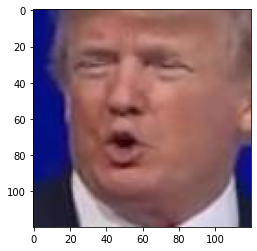

In [ ]:
%matplotlib inline
plt.figure()
plt.imshow(X_test_a[30])
plt.show()

23/23 [==============================] - 31s 1s/step - loss: 0.0254


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


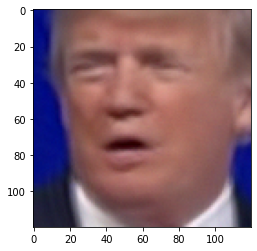

In [ ]:
autoencoder_a = load_model("/content/trained_autoencoders/autoencoder_a.hdf5")
autoencoder_a.evaluate(X_test_a, X_test_a)
output_image = autoencoder_a.predict(np.array([X_test_a[30]]))
plt.figure()
plt.imshow(output_image[0])
plt.show()

Rozpoczęcie uczenia autoencodera na podstawie klatek z Joe Bidenem. Taka sama sytuacja jak wyżej. 

In [ ]:
checkpoint2 = ModelCheckpoint("/content/autoencoder_b.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='auto', period=1)
history2 = autoencoder.fit(X_train_b, X_train_b,epochs=2700,batch_size=512,shuffle=True,validation_data=(X_test_b, X_test_b),callbacks=[checkpoint2])

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
3/3 [==============================] - 5s 2s/step - loss: 0.0505 - val_loss: 0.0526
Epoch 1451/2700
3/3 [==============================] - ETA: 0s - loss: 0.0503
Epoch 1451: val_loss did not improve from 0.05185
3/3 [==============================] - 5s 2s/step - loss: 0.0503 - val_loss: 0.0530
Epoch 1452/2700
3/3 [==============================] - ETA: 0s - loss: 0.0503
Epoch 1452: val_loss did not improve from 0.05185
3/3 [==============================] - 5s 2s/step - loss: 0.0503 - val_loss: 0.0529
Epoch 1453/2700
3/3 [==============================] - ETA: 0s - loss: 0.0506
Epoch 1453: val_loss did not improve from 0.05185
3/3 [==============================] - 5s 2s/step - loss: 0.0506 - val_loss: 0.0532
Epoch 1454/2700
3/3 [==============================] - ETA: 0s - loss: 0.0496
Epoch 1454: val_loss improved from 0.05185 to 0.05166, saving model to /content/autoencoder_b.hdf5
3/3 [==============================] -

In [ ]:
!cp '/content/drive/My Drive/DeepFake/autoencoder_b.hdf5' /content/trained_autoencoders/

Porównanie obrazu testowego z obrazem otrzymanym z autoencodera. Efekt podobny

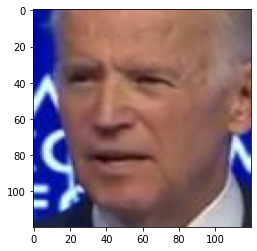

In [ ]:
plt.figure()
plt.imshow(X_test_b[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


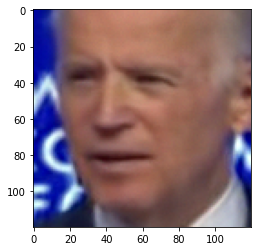

In [ ]:
autoencoder_b = load_model("/content/trained_autoencoders/autoencoder_b.hdf5")
autoencoder_a.evaluate(X_test_b, X_test_b)
output_image = autoencoder_b.predict(np.array([X_test_b[0]]))
plt.figure()
plt.imshow(output_image[0])
plt.show()

Zakończył się tutaj etap wstępnego przygotowania danych i uczenia autoencoderów. Teraz wykorzystamy utworzone autoencodery aby utworzyć video deepfake z podmienieniem twarzy. 

Najpierw przygotujemy źródłowe klatki z filju Trumpa i będziemy je przechowywać według ich pojawienia się w wideo

In [ ]:
def extract_frames(input_path,output_path):
    videocapture = cv2.VideoCapture(input_path)
    success,image = videocapture.read()
    count = 0
    while success:
        cv2.imwrite(output_path+"%d.jpg" % count, image)     
        success,image = videocapture.read()
        count += 1
    print('Frames extraction has ended')
    return count

Wywołanie powyższej funkcji na wideo w celu wyodrębnienia poszczególnych klatek

In [ ]:
frames = extract_frames(input_1, '/content/frames/')

Frames extraction has ended


Wyodrębnienie twarzy z klatek źródła i zapisanie ich pod tą samą nazwą, co odpowiadające im klatki. Został użyty tutaj ten sam detektor twarzy co wyżej z taką samą modyfikacją

In [ ]:
!pip install mtcnn
from mtcnn import MTCNN
 
def extract_faces(source,destination,detector):
    counter = 0
    for dirname, _, filenames in os.walk(source):
        for filename in filenames:
            try:
                image = cv2.imread(os.path.join(dirname, filename))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                detections = detector.detect_faces(image)
                x, y, width, height = detections[0]['box']
                x1,y1,x2,y2 = x-10,y+10,x-10 +width + 20,y+10+height
                face = image[y1:y2, x1:x2]
                face = cv2.resize(face, (120, 120), interpolation=cv2.INTER_LINEAR)
                plt.imsave(os.path.join(destination,filename),face)
                clear_output(wait=True)
                print("Extraction progress: "+str(counter)+"/"+str(len(filenames)-1))
            except:
                pass
            counter += 1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Wywołanie powyższej funkcji aby wyekstraktować twarze z poszczególnych klatek filmu

In [ ]:
detector = MTCNN()
extract_faces('/content/frames/', '/content/results/',detector)

Extraction progress: 1700/1700


Potwierdzenie wyekstraktowania twarzy

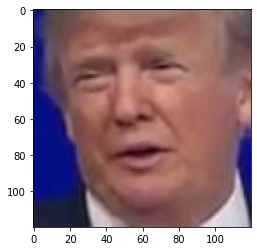

In [ ]:
%matplotlib inline
plt.figure()
image = cv2.imread('/content/results/120.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

Wczytanie modeli autoencoder'ów, które wczesniej zostały wytrenowane i pobrane z dysku google 

In [ ]:
autoencoder_a = load_model("/content/trained_autoencoders/autoencoder_a.hdf5")
autoencoder_b = load_model("/content/trained_autoencoders/autoencoder_b.hdf5")

Mając wyszkolone autoencodery mamy dostęp do ich poszczególnych komponentów czyli do encodera i decodera. W naszym przypadku chcemy na twarz Donalda Trumpa nałożyć twarz Joe Bidena. Dlatego jak encoder wybierzemy ten z autoencodera wyszkolonego na Trumpie a jako decoder wbierzemy ten wyszkolony na Bidenie.

---



In [ ]:

# encoder Trumpa
encoder = keras.Model(autoencoder_a.layers[1].input, autoencoder_a.layers[1].output)
# decoder Trumpa
# decoder = keras.Model(autoencoder_a.layers[2].input, autoencoder_a.layers[2].output)
# ecoder Bidena
# encoder = keras.Model(autoencoder_b.layers[1].input, autoencoder_b.layers[1].output)
# decoder Bidena
decoder = keras.Model(autoencoder_b.layers[2].input, autoencoder_b.layers[2].output)

Pozostało nam jedynie odtworzyć twarz Trumpa z twarzą Bidena. Wykonamy to w jednej metodzie face_tranform, która również przygotuje klatki tak aby można je było wykorzystać do tranformacji i odpowiednio je zapisze.  To tutaj na wejście encodera wrzucamy klatki z Trumpem. Otrzymujemy je wtedy skompresowane i podajemy je na wejście encodera Bidena dzięki czemu twarz Trumpa połączy się z twarzą Bidena. 

In [ ]:
def face_transform(source,destination,encoder,decoder):
    counter = 0
    for dirname, _, filenames in os.walk(source):
        for filename in filenames:
            # load the image
            try:
                image = cv2.imread(os.path.join(source, filename))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = image.astype('float32')
                image /= 255.0
                image = encoder.predict(np.array([image]))
                image = decoder.predict(image)
                image = cv2.normalize(image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
                image = image.astype(np.uint8)
                plt.imsave(os.path.join(destination,filename),image[0])
                counter += 1
                clear_output(wait=True)
                print("Transformation progress: "+str(counter)+"/"+str(len(filenames)))
            except:
                print('exception')
                Pass

Wywoałanie powyższej metody

In [ ]:
face_transform('/content/results/','/content/transformed',encoder_a,decoder_b)

Transformation progress: 1701/1701


Wyświetlenie zmodyfikowanej twarzy aby potwierdzić działanie autoencodera jeśli chodzi o transformacje jednej twarzy w drugą. Tak jak pisalismy wyżej, z powodu małej ilości epok efekt nie będzie najlepszy, jednak widać wyraźnie że obraz został odtworzony tak jak chcieliśmy czyli na twarz Trumpa nałożyła się twarz Bidena. 

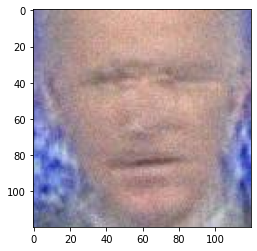

In [ ]:
%matplotlib inline
plt.figure()
image = cv2.imread('/content/transformed/120.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

Aby optymalnie podmienić twarze na wideo z trumpem wykorzystalismy napisany już program, który zrobi to bardzo dobrze. 

In [ ]:
!git clone https://github.com/PiotrApriasz/faceswap.git

Cloning into 'faceswap'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 38 (delta 2), reused 0 (delta 0), pack-reused 32
Unpacking objects: 100% (38/38), done.


Funkcja zamiany twarzy przy użyciu zmienionego skryptu

In [ ]:
def massive_face_swap(source,destination,output):
    counter = 0
    for dirname, _, filenames in os.walk(source):
        for filename in filenames:
            current_src = os.path.join(dirname, filename)
            current_dst = os.path.join(destination, filename)
            current_out = os.path.join(output, filename)
            !python /content/faceswap/faceswap.py {current_dst} {current_src} {current_out}
            clear_output(wait=True)
            print("Swap progress: "+str(counter)+"/"+str(len(filenames)-1))
            counter += 1

In [ ]:
!cp '/content/drive/My Drive/DeepFake/shape_predictor_68_face_landmarks.dat' /content/shape_predictor/

Wywołanie powyższej funckji

In [ ]:
massive_face_swap('./transformed','./frames','./final')

Swap progress: 1700/1700


Przykład działania powyższej funkcji i porównanie z oryginalną klatką. Jest to przedsmak tego jak będzie wyglądał nasz deepfake. jakość pozostawia wiele do życzenia jednak efekt został uzyskany i w twarzy trumpa można dostrzec twarz Bidena. 

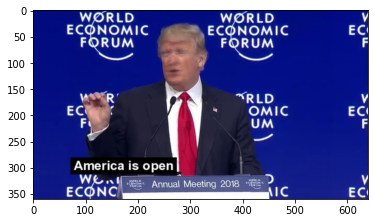

In [ ]:
%matplotlib inline
plt.figure()
image = cv2.imread('/content/final/150.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

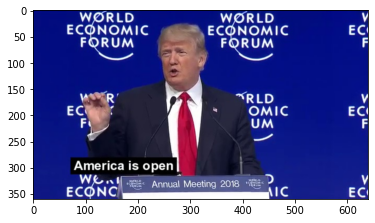

In [ ]:
plt.figure()
image = cv2.imread('/content/frames/150.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

Odworzenie wideo z użyciem wytworzonych obrazów zamiast oryginalnych klatek. Otrzymujemy tutaj nasz finalny deepfake i zapusuemy go na dysku google. 

In [ ]:
frames = []
for i in range(1701):
    image = image = cv2.imread(os.path.join('/content/final', str(i)+'.jpg'))
    height, width, layers = image.shape
    frames.append(image)
frames = np.array(frames)
videomaker = cv2.VideoWriter('/content/deepfake.avi', cv2.VideoWriter_fourcc(*'DIVX'), 25, (width,height))
 
for frame in frames:
    videomaker.write(frame)
 
videomaker.release()

In [ ]:
!cp  /content/deepfake.avi '/content/drive/My Drive/DeepFake/'

Kolejnym krokiem będzie sprawdzenie jak autoencoder poradzi sobie z odtworzeniem postaci Bidena na podstawie klatek z deepfake Trumpa podanych na wejście autoencoderowi wyszkolonemu na Bidenie. Robimy tak dlatego, ponieważ tworząc ten deepfake chcieliśmy na twarz Trumpa nałożyć twarz Bidena, aby wydawało się, że to Biden mówi słowa, które wypowiedział Trump. Chcemy w ten sposób sprawdić czy wideo zostało oszukane. Autoencodery bardzo dobrze radzą sobie z wykrywaniem anomali, to znaczy kiedy na wejście podamy zupełnie inne lub zmodyfikowane dane w stosunku do tych na których był wyuczony, gorzej poradzi on sobie z odtworzeniem takich danych co w połączeniu z użyciem odpowiedniej funkcji straty pozwoli określić, że coś jest anomalią. W tym wypadku określimy w ten sposób czy podane obrazy to deepfake. 
Na początek skopiujemy utworzone wideo z dysku Google

In [ ]:
!cp '/content/drive/My Drive/DeepFake/deepfake.avi' /content/deepfake_video/

Wyekstraktowanie pojedynczych klatek z filmu

In [ ]:
extract_frames('/content/deepfake_video/deepfake.avi', '/content/deepfake_frames/')

1701

Znalezienie twarz na klatkach filmu i zapisanie ich jako osobne obrazy

In [ ]:
detector = MTCNN()
extract_faces('/content/deepfake_frames/', '/content/deepfake_faces/',detector)

Extraction progress: 1700/1700


Przesłanie utworzonych klatek z twarzami na dysk google

In [ ]:
!cp -r '/content/deepfake_faces/' '/content/drive/My Drive/DeepFake/deepfake_faces' 

Skopiowanie klatek z twarzami z dysku google jeśli nie są dostępne na serwerze

In [ ]:
!cp -r '/content/drive/My Drive/DeepFake/deepfake_faces/' '/content/deepfake_faces/'

Przetworzenie obrazów tak aby mogły być odczytanie przez autoencoder

In [ ]:
deepfake_faces = create_dataset('/content/deepfake_faces/')

Podzielenie datasetu tak aby klatki mogły być użyte w autoencoderze 

In [ ]:
X_deepfake_train_a, X_deepfake_test_a, y_deepfake_train_a, y_deepfake_test_a = train_test_split(deepfake_faces, deepfake_faces, test_size=0.20, random_state=0)

Uzyjemy teraz autoencodera wyszkolonego na Bidenie do odtworzenia obrazów z wejścia. Na początku ocenimy zdolność autoencodera do odtworzenia obrazów z wejścia. Najpierw zostanie wykonane to dla testowego datasetu z oryginału Bidena a później dla testowego datasetu z deepfake Trumpa/Bidena. Dodatkowo Pokażemy jakość odtworzeń wybranych klatek przez autoencoder

11/11 [==============================] - 16s 1s/step - loss: 0.1297


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


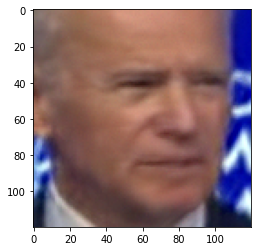

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


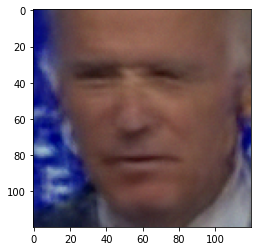

In [ ]:
autoencoder_b = load_model("/content/trained_autoencoders/autoencoder_b.hdf5")
autoencoder_b.evaluate(X_test_b, X_test_b)
autoencoder_b.evaluate(X_deepfake_test_a, X_deepfake_test_a)

output_images_original_one = autoencoder_b.predict(np.array([X_test_b[30]]))
output_images_deepfake_one = autoencoder_b.predict(np.array([X_deepfake_test_a[30]]))

plt.figure()
plt.imshow(output_images_original_one[0])
plt.show()

plt.figure()
plt.imshow(output_images_deepfake_one[0])
plt.show()



Jak widzimy na outpucie mamy większą stratę dla przypadku gdzie na wejście podaliśmy deepfake. Jest to różnica dosyć duża co już pozwoliłoby nam określić to, że na wejściu podaliśmy oszukane wideo, które tylko udaje Bidena. Widać też, że odtworzony obraz z deepfake jest dużo gorszej jakości. Odtowrzymy teraz obrazy i zapiszemy w tablicach, a do określenia straty użyjemy innej funkcji straty, aby jeszcze dokładnie określić czy mamy do czynienia z deepfake

In [ ]:
output_images_original = autoencoder_b.predict(X_test_b)
output_images_deepfake = autoencoder_b.predict(X_deepfake_test_a)

Funkcja  wykorzystująca SSIM z Tensorflow czyli funkcje określającą jakie straty ma jeden obraz w stosunku do drugiego 

In [ ]:
def loss(a_pred, b_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(a_pred, b_pred,1.0))

Wywołanie powyższej funkcji w celu porównania setu testowego Bidena z obrazami odtworzonymi z autoencodera na podstawie obrazów testowych

In [ ]:
error_vals = 0

for i in range(340): 
  value = loss(output_images_original[i], X_test_b[i])
  info = '{:.3f}'
  error_vals = error_vals + float(info.format(value))

print(error_vals / 340)

0.13710882352941187


Wywołanie funkcji błędu w celu porównania odtworzonych obrazów z setu testowego Bidena z obrazami odtworzonymi na podstawie obrazów z deepfake

In [ ]:
error_vals = 0

for i in range(340): 
  value = loss(output_images_deepfake[i], output_images_original[i])
  info = '{:.3f}'
  error_vals = error_vals + float(info.format(value))

print(error_vals / 340)
  

0.5244911764705884


Widzimy tutaj, że obrazy z deepfake są znacznie gorzej odtworzone (Mają zdecydowanie większą średnią wartość błędu) w porównaiu do obrazów odtworzonych z oryginalnego setu testowego. Dzięki temu możemy już jasno określić, że wideo to deepfake. Warto jednak zwrócić uwagę, że w naszym przypadku jakość deepfake'a budzi wątpliwości z racji niewystarczającej ilości epok uczenia, co było spowodowane bardzo długim czasem potrzebnym na dobre nauczenie sieci, dlatego możliwe, że to ułatwiło pracę autoencoderowi i funkcji straty. Jednakże z drugiej strony lepiej wyszkolony autoencoder radziłby sobie znacznie lepiej z odwzorowywaniem oryginalnych obrazów zachowując ich najbardziej istotne cechy co oznacza również to, że mimo, że deepfake byłby znacznie lepszej jakości to i tak strata odtworzenia byłaby większa ponieważ deepfake nie miałby tylu tych cech, których wyuczył sie dobrze wyszkolony autoencoder. 